In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
from sklearn import metrics
from sklearn import preprocessing
from sklearn import  linear_model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tools.tools import add_constant
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.compat import lzip
import csv
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
import seaborn as sn
import statistics
from scipy import stats

data.csv includes lastest edition FIFA 2019 players attributes like Age, Nationality, Overall, Club,              
Wage, Preferred_Foot, Position, Height, Weight, ShortPassing, FKAccuracy, LongPassing, BallControl, Acceleration, SprintSpeed, Agility, Reactions, Balance, ShotPower, Jumping, Stamina, Strength, LongShots, Positioning, Penalties.  

Данные включают в себя последние издания FIFA 2019 игроков атрибуты, такие как Возраст, Национальность, Общий, Клуб, Заработная плата, Предпочтительная нога, Положение, Рост, Вес, Шортпассинг, Точность FK,Long Passing, Контроль мяча, Ускорение, Скорость спринта, Ловкость,Реакции, баланс, сила удара, прыжки, выносливость, сила,Длинные выстрелы, Позиционирование, Пенальти

In [2]:
master_data=pd.read_csv('data.csv')
master_data.head()
master_data.drop(columns = ['Unnamed: 0','Name','ID','WorkRate','BodyType','RealFace','LoanedFrom','Value','InternationalReputation','Joined','WeakFoot','GKDiving', 'GKHandling','GKKicking', 'GKPositioning','Aggression','Vision','Vision','Special', 'SkillMoves','Volleys', 'Dribbling', 'Curve','Interceptions', 'HeadingAccuracy','Crossing', 'Potential','Finishing', 'GKReflexes', 'ReleaseClause','ContractValidUntil','JerseyNumber','Flag','ClubLogo','LS','ST','RS','LW','LF','CF','RF','RW','LAM','CAM','RAM','LM','LCM','CM','RCM','RM','LWB','LDM','CDM','RDM','RWB','LB','LCB','CB','RCB','RB','Photo','Composure', 'Marking', 'StandingTackle', 'SlidingTackle'], inplace=True)
master_data.columns.str.strip()
master_data.rename(columns = {'PreferredFoot':'Preferred_Foot'                              
                             }, inplace = True)
master_data.fillna(master_data.mean(), inplace=True)
# 

Подготовка данных, убираем NaN значения - заменяем на среднее значение, переводим единицы измерения к русским и обрабатываем категориальные признаки

In [3]:
master_data['Wage'] = master_data.Wage.str.replace('€','')
master_data['Wage'] = master_data.Wage.str.replace('K','000')
master_data['Wage'] = master_data.Wage.astype('int64')
master_data['Weight'] = master_data.Weight.str.replace('lbs','').astype('float64')
master_data['Height'] = master_data.Height.str.replace('\'','.').astype('float64')
master_data.fillna(0, inplace=True)
master_data['Preferred_Foot'] = master_data.Preferred_Foot.astype('category')
master_data['Nationality'] = master_data.Nationality.astype('category')
master_data['Club'] = master_data.Club.astype('category')
master_data['Position'] = master_data.Position.astype('category')
master_data['Weight'] = master_data.Weight*0.454
master_data['Height'] = master_data.Height*30

In [4]:
master_data.head()

Age Nationality  Overall                Club    Wage Preferred_Foot  \
0   31   Argentina       94         FCBarcelona  565000           Left   
1   33    Portugal       94            Juventus  405000          Right   
2   26      Brazil       92  ParisSaint-Germain  290000          Right   
3   27       Spain       91    ManchesterUnited  260000          Right   
4   27     Belgium       91      ManchesterCity  355000          Right   

  Position  Height  Weight  ShortPassing    ...      Agility  Reactions  \
0       RF   171.0  72.186          90.0    ...         91.0       95.0   
1       ST   186.0  83.082          81.0    ...         87.0       96.0   
2       LW   177.0  68.100          84.0    ...         96.0       94.0   
3       GK   192.0  76.272          50.0    ...         60.0       90.0   
4      RCM   153.3  69.916          92.0    ...         79.0       91.0   

   Balance  ShotPower  Jumping  Stamina  Strength  LongShots  Positioning  \
0     95.0       85.0     68.0     72.0      59.0       94.0         94.0   
1     70.0       95.0     95.0     88.0      79.0       93.0         95.0   
2     84.0       80.0     61.0     81.0      49.0       82.0         89.0   
3     43.0       31.0     67.0     43.0      64.0       12.0         12.0   
4     77.0       91.0     63.0     90.0      75.0       91.0         87.0   

   Penalties  
0       75.0  
1       85.0  
2       81.0  
3       40.0  
4       79.0  

[5 rows x 25 columns]

Для данного массива проведем статистический анализ каждой переменной, вычислив ее выборочные числовые характеристики: среднее, дисперсию, моду, медиану, эксцесс, асимметрию, коэффициент вариации, размах.

In [5]:
cols = ['Mean', 'Mode', 'Median', 'Variance', 'Skew', 'Kurtosis', 'Range', 'Std', 'k variation']
temp= []
dt_stat = pd.DataFrame(columns=cols)
pre_dt = 0
for name, values in master_data.iteritems():
    if (master_data[name].dtype.name != 'category'):
#         temp.append(name)
        temp.append(statistics.mean(master_data[name]))
        temp.append(statistics.mode(master_data[name]))
        temp.append(statistics.median(master_data[name]))
        temp.append(statistics.variance(master_data[name]))
        temp.append(stats.skew(master_data[name]))
        temp.append(stats.kurtosis(master_data[name]))
        temp.append(np.max(master_data[name])-np.min(master_data[name]))
        temp.append(np.std(master_data[name]))
        temp.append(np.std(master_data[name])/statistics.mean(master_data[name])*100)  
        dt_stat.loc[name] = temp
        temp=[]
        pre_dt = pre_dt+1
print(dt_stat)
        

                     Mean     Mode   Median      Variance      Skew  \
Age             25.122206    21.00    25.00  2.180836e+01  0.391732   
Overall         66.238699    66.00    66.00  4.773331e+01  0.067179   
Wage          9731.312133  1000.00  3000.00  4.839688e+08  7.905368   
Height         173.462498   180.00   177.00  2.598840e+02 -3.541539   
Weight          75.155864    74.91    74.91  6.491681e+01 -1.936397   
ShortPassing    58.686712    64.00    62.00  2.155055e+02 -1.101678   
FKAccuracy      42.863153    42.00    41.00  3.047017e+02  0.102244   
LongPassing     52.711933    62.00    56.00  2.343242e+02 -0.596378   
BallControl     58.369459    65.00    63.00  2.777084e+02 -1.269433   
Acceleration    64.614076    69.00    67.00  2.222511e+02 -0.816311   
SprintSpeed     64.726967    68.00    67.00  2.140553e+02 -0.829612   
Agility         63.503607    68.00    66.00  2.174614e+02 -0.600158   
Reactions       61.836610    65.00    62.00  8.097442e+01 -0.114268   
Balanc

Визуализация разброса каждого фактора

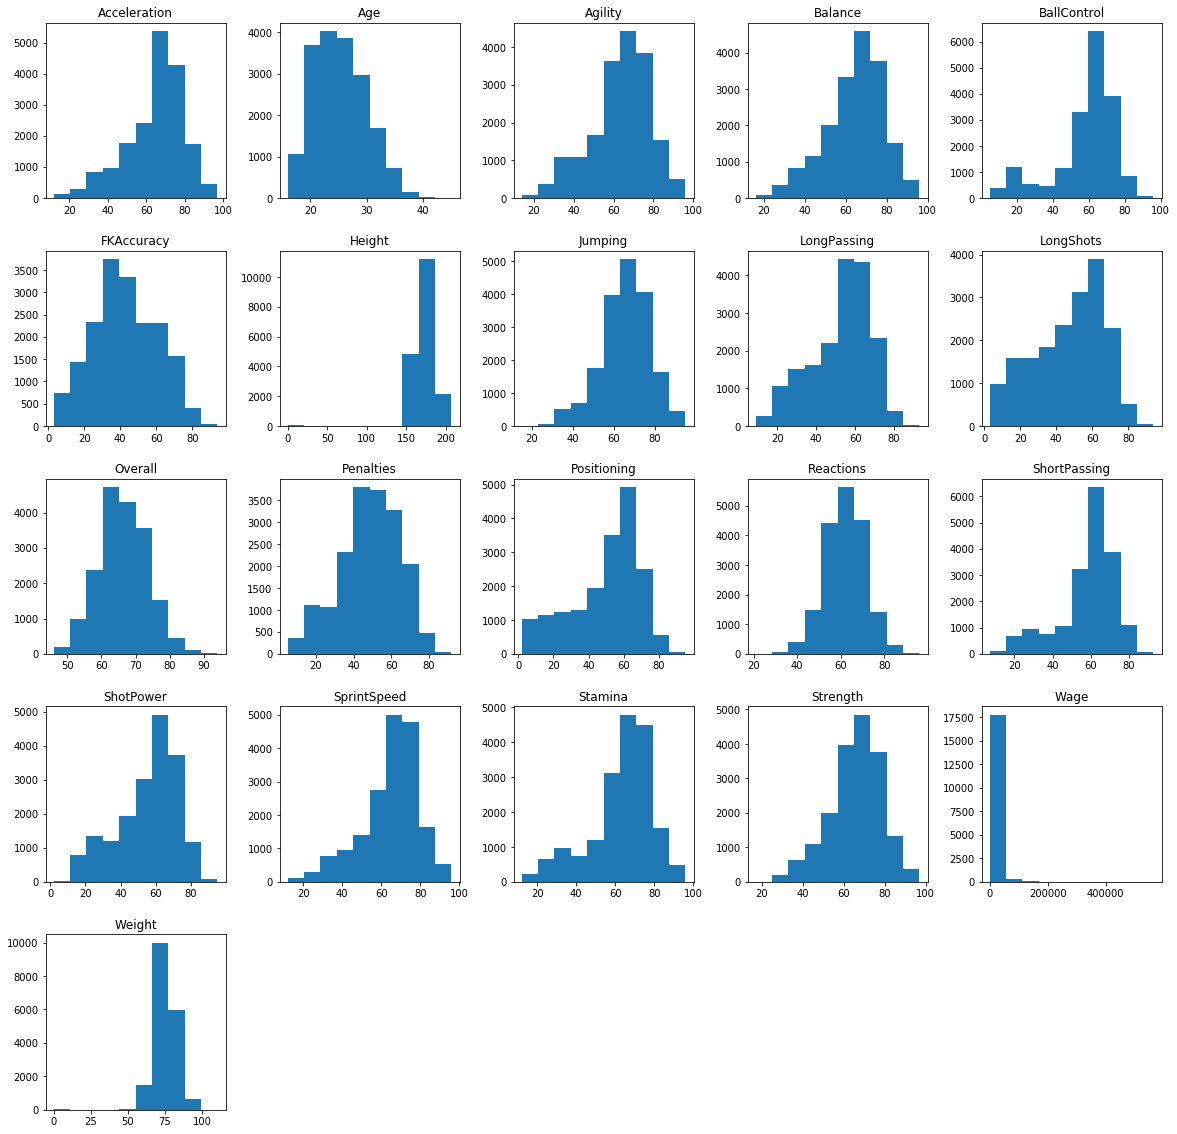

In [20]:
histohrams = master_data.hist(grid=False, figsize=(20, 20))

Построим корреляционную матрицу для вычисления тесноты связей между зависимой переменной и каждым фактором

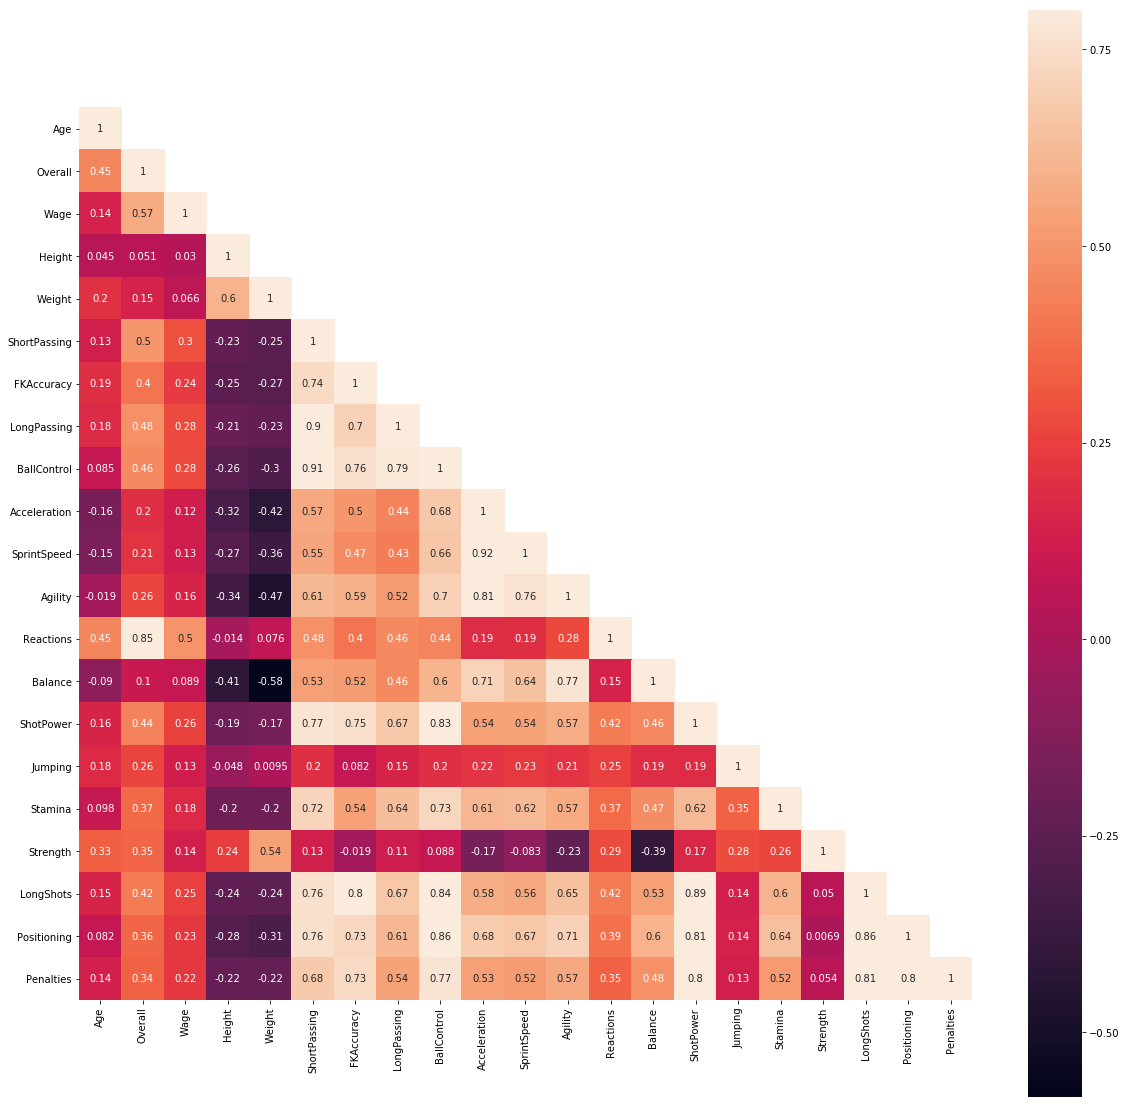

In [8]:
corr = master_data.corr()
mask = np.array(corr)
mask[np.tril_indices_from(mask)] = False
fig,ax = plt.subplots()
fig.set_size_inches(20,20)
sn.heatmap(corr, mask=mask, vmax=.8, square=True, annot = True)

Построим уравнение множественной линейной регрессии, включив в модель все имеющиеся факторы.

Набор обучающих данных будет использоваться для обучения нашей линейной модели. Тестовый набор данных будет использоваться для проверки модели. Все данные из тестового набора данных будут новыми для модели, и мы сможем проверить, насколько точны прогнозы модели.

In [6]:
X = master_data.drop(['Overall',
                     'Nationality',
                      'Club',
                      'Preferred_Foot',
                      'Position'], axis=1)
Y = master_data['Overall']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4)

Коэффициенты регрессии

In [7]:
lin_reg = linear_model.LinearRegression()
lin_reg.fit(X_train, Y_train)
cdf = pd.DataFrame(lin_reg.coef_,X.columns, columns=['Coefficients'])
print(cdf)
print("Independent term in the model "+ str(lin_reg.intercept_))

              Coefficients
Age               0.156836
Wage              0.000061
Height            0.012364
Weight            0.053033
ShortPassing      0.044181
FKAccuracy        0.001934
LongPassing       0.012658
BallControl       0.049891
Acceleration      0.029256
SprintSpeed       0.019066
Agility           0.026084
Reactions         0.473095
Balance          -0.041956
ShotPower         0.017594
Jumping           0.015023
Stamina          -0.025857
Strength          0.021120
LongShots         0.009538
Positioning      -0.056424
Penalties        -0.015454
Independent term in the model 19.411193324065763


Сравниваем предсказанное с тестом

In [8]:
Y_pred = lin_reg.predict(X_test)
print('Prediction:', len(Y_pred))
# средне квадратическая ошибка
mse = mean_squared_error(Y_test, Y_pred)
print('mean_squared_error : ',mse)

Prediction: 7283
mean_squared_error :  9.809558211598599


In [13]:
alfa = 0.05
n = Y_pred.size-1
t = stats.t(n)
tcr = t.ppf(1-alfa/2)
print ("t-stat ", tcr)
print ("<queue_mean>", np.mean(Y_pred), "</queue_mean>")
print ("<queue_di>", tcr*np.std(Y_pred)/np.sqrt(Y_pred.size), "</queue_di>")

t-stat  1.9602898097086714
<queue_mean> 66.27245632392938 </queue_mean>
<queue_di> 0.14177778021855453 </queue_di>


In [10]:
#R^2 (coefficient of determination) regression score function.
r2 = r2_score(Y_test, Y_pred)
print('r2 score from scipy: ',r2)
r2_adj = 1-((1-r2*r2)*(Y_pred.size-1)/(Y_pred.size-1-len(X_test.columns)))
print('r2_adj', r2_adj)

r2 score from scipy:  0.7927206927347716
r2_adj 0.6273827039515043


МНК

In [11]:
X2 = sm.add_constant(X_train)
est = sm.OLS(Y_train, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                Overall   R-squared:                       0.799
Model:                            OLS   Adj. R-squared:                  0.799
Method:                 Least Squares   F-statistic:                     2170.
Date:                Wed, 10 Apr 2019   Prob (F-statistic):               0.00
Time:                        20:02:47   Log-Likelihood:                -27876.
No. Observations:               10924   AIC:                         5.579e+04
Df Residuals:                   10903   BIC:                         5.595e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           19.4112      0.572     33.955   

In [14]:
abs(est2.tvalues) > tcr

const            True
Age              True
Wage             True
Height           True
Weight           True
ShortPassing     True
FKAccuracy      False
LongPassing      True
BallControl      True
Acceleration     True
SprintSpeed      True
Agility          True
Reactions        True
Balance          True
ShotPower        True
Jumping          True
Stamina          True
Strength         True
LongShots        True
Positioning      True
Penalties        True
dtype: bool

Незначимы: FKAccuracy

In [278]:
X3 = add_constant(X2)
pd.Series([vif(X3.values, i) 
               for i in range(X3.shape[1])], 
              index=X3.columns)

const           382.541618
Age               1.580413
Wage              1.366175
Height            1.564009
Weight            2.484956
ShortPassing     12.259899
FKAccuracy        3.782775
LongPassing       6.206683
BallControl      12.033104
Acceleration      8.835595
SprintSpeed       7.317212
Agility           4.557043
Reactions         2.076202
Balance           3.564149
ShotPower         6.192460
Jumping           1.364222
Stamina           3.029599
Strength          2.637762
LongShots         7.871212
Positioning       6.456343
Penalties         3.916688
dtype: float64

Получается так. Часто используют границу 5 или 10, если показатель VIF больше данного значения - есть линейная зависимость от остальных переменных

Если VIF (Variance Inflation Factor) возле каждой независимой переменной меньше 10 — значит, эффекта мультиколлинеарности не наблюдается и регрессионная модель приемлема для дальнейшей интерпретации. Чем выше показатель VIF, тем более связаны между собой переменные

Добавляем значимые переменные в модель

In [279]:
col = ['Wage']
XX = X_train[col]
X2 = sm.add_constant(XX)
est = sm.OLS(Y_train, X2)
est2 = est.fit()
print(est2.rsquared_adj)

0.32398041748847384


In [280]:
col.append('Age')
XX = X_train[col]
X2 = sm.add_constant(XX)
est = sm.OLS(Y_train, X2)
est2 = est.fit()
print(est2.rsquared_adj)

0.4642980075579102


In [281]:
col.append('Reactions')
XX = X_train[col]
X2 = sm.add_constant(XX)
est = sm.OLS(Y_train, X2)
est2 = est.fit()
print(est2.rsquared_adj)

0.7643356236149644


In [283]:
col.append('Balance')
XX = X_train[col]
X2 = sm.add_constant(XX)
est = sm.OLS(Y_train, X2)
est2 = est.fit()
print(est2.rsquared_adj)

0.764434750930771


In [284]:
col.append('Height')
XX = X_train[col]
X2 = sm.add_constant(XX)
est = sm.OLS(Y_train, X2)
est2 = est.fit()
print(est2.rsquared_adj)

0.7666832951717623


In [285]:
col.append('Weight')
XX = X_train[col]
X2 = sm.add_constant(XX)
est = sm.OLS(Y_train, X2)
est2 = est.fit()
print(est2.rsquared_adj)

0.7696056090592169


In [286]:
col.append('BallControl')
XX = X_train[col]
X2 = sm.add_constant(XX)
est = sm.OLS(Y_train, X2)
est2 = est.fit()
print(est2.rsquared_adj)

0.7854961845259942


In [287]:
col.append('Positioning')
XX = X_train[col]
X2 = sm.add_constant(XX)
est = sm.OLS(Y_train, X2)
est2 = est.fit()
print(est2.rsquared_adj)

0.7893895172808139


In [288]:
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                Overall   R-squared:                       0.790
Model:                            OLS   Adj. R-squared:                  0.789
Method:                 Least Squares   F-statistic:                     5119.
Date:                Mon, 08 Apr 2019   Prob (F-statistic):               0.00
Time:                        15:58:42   Log-Likelihood:                -28140.
No. Observations:               10924   AIC:                         5.630e+04
Df Residuals:                   10915   BIC:                         5.636e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          21.3090      0.576     37.001      

In [289]:
X3 = add_constant(X2)
pd.Series([vif(X3.values, i) 
               for i in range(X3.shape[1])], 
              index=X3.columns)

const          357.877442
Wage             1.351951
Age              1.341589
Reactions        1.956506
Balance          2.281665
Height           1.540859
Weight           2.051814
BallControl      4.460234
Positioning      4.074060
dtype: float64

In [290]:
np.linalg.cond(est2.model.exog)

455845.54474251176

In [291]:
np.abs(est2.params/np.std(Y_train)*np.std(X_train[col])).sort_values(ascending = False)

Reactions      0.640065
BallControl    0.276047
Wage           0.188653
Positioning    0.126214
Age            0.100791
Weight         0.075194
Balance        0.036141
Height         0.026179
const               NaN
dtype: float64

In [292]:
np.abs(est2.params/np.mean(Y_train)*np.mean(X_train[col])).sort_values(ascending = False)

Reactions      0.457256
BallControl    0.101906
Weight         0.074773
Age            0.056662
Positioning    0.034123
Height         0.030139
Balance        0.017199
Wage           0.008677
const               NaN
dtype: float64

In [293]:
np.mean(lin_reg.predict(X_train) - Y_train)

1.0169008724710185e-14

Так как значение получилось близко к нулю, то считается, что модель не содержит систематической ошибки и адекватна по критерию нулевого среднего

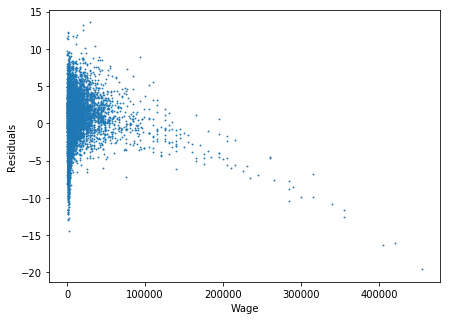

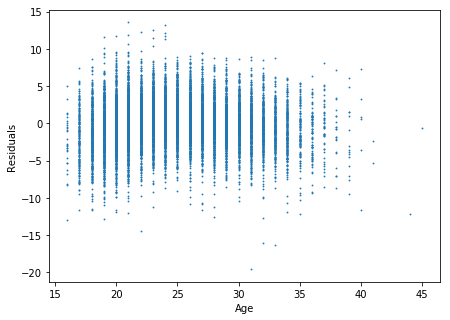

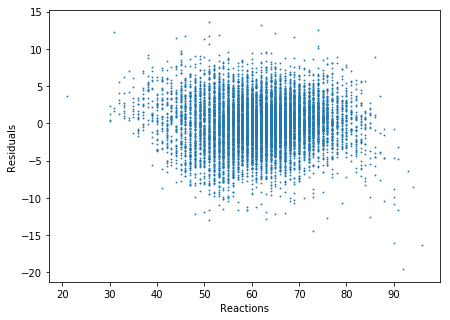

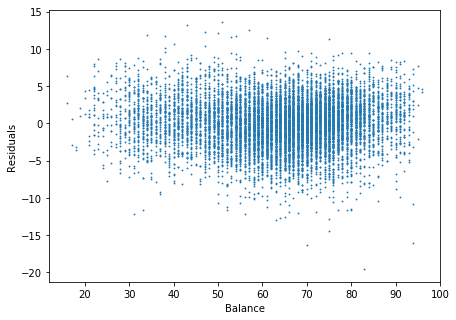

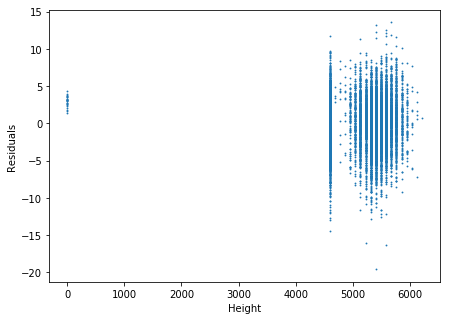

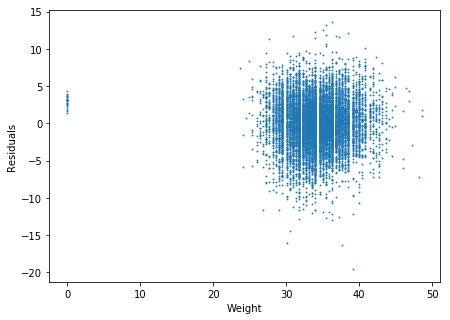

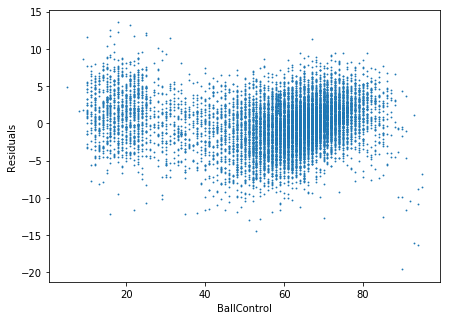

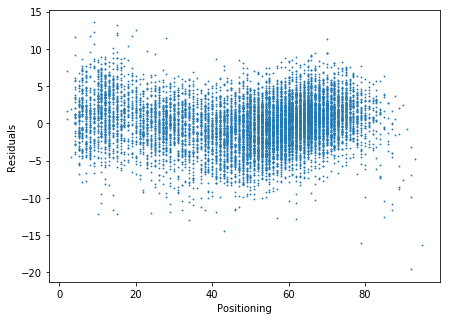

In [294]:
for i, j in enumerate(col):
    plt.figure(figsize=(7,5))
    plt.scatter(X_train[j], est2.resid, s=0.7)
    plt.xlabel(j)
    plt.ylabel('Residuals')

plt.show()


In [295]:
name = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
test = het_breuschpagan(est2.resid, est2.model.exog)
lzip(name, test)

[('Lagrange multiplier statistic', 796.0077142393163),
 ('p-value', 1.492482699510026e-166),
 ('f-value', 107.23280532531493),
 ('f p-value', 5.0074989086492316e-173)]

f_pvalue = 0, поэтому H0(гомоскедастичность) отклоняется.

In [296]:
durbin_watson(est2.resid)

2.006628300042474

~2, следовательно, нет автокорреляциии